# Re-calibration of a diffraction image with Jupyter

Jupyter notebooks (and jupyterlab) are standard tools to perfrom data analysis. 
While there are plenty of tutorial on the usage of pyFAI for azimuthal integration, few of then address the need for calculating the geometry of the experimental setup, also because the tool is not yet completely ready...

In this example we will perform the precise calibration of an image which setup is roughly known.

In [1]:
%matplotlib inline
import time
from matplotlib.pyplot import subplots
from pyFAI.gui import jupyter
import pyFAI
import fabio
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.goniometer import SingleGeometry
print(f"Using pyFAI version: {pyFAI.version}")
start_time = time.perf_counter()

Using pyFAI version: 0.20.0-beta1


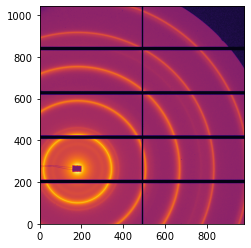

In [2]:
# In this example, we will re-use one of the image used int the test-suite
filename = UtilsTest.getimage("Pilatus1M.edf")
frame = fabio.open(filename).data
# and now display the image
ax = jupyter.display(frame)

In [3]:
# This allow to measure approximatively the position of the beam center ...
x = 200 # x-coordinate of the beam-center in pixels
y = 300 # y-coordinate of the beam-center in pixels
d = 1600 # This is the distance in mm (unit used by Fit2d)
wl = 1e-10 # The wavelength is 1 Å

In [4]:
# Definition of the detector and of the calibrant:
pilatus = pyFAI.detector_factory("Pilatus1M")
behenate = CALIBRANT_FACTORY("AgBh")
behenate.wavelength = wl
behenate

AgBh Calibrant with 49 reflections at wavelength 1e-10

In [5]:
# Set the guessed geometry
initial = pyFAI.geometry.Geometry(detector=pilatus, wavelength=wl)
initial.setFit2D(d,x,y)
initial

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.600000e+00m	PONI= 5.160000e-02, 3.440000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1600.000mm	Center: x=200.000, y=300.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

In [6]:
# The SingleGeometry object (from goniometer) allows to extract automatically ring and calibrate
sg = SingleGeometry("demo", frame, calibrant=behenate, detector=pilatus, geometry=initial)
sg.extract_cp(max_rings=5)

ControlPoints instance containing 5 group of point:
AgBh Calibrant with 49 reflections at wavelength 1e-10
Containing 5 groups of points:
# a ring 0: 181 points
# b ring 1: 206 points
# c ring 2: 151 points
# d ring 3: 133 points
# e ring 4: 67 points

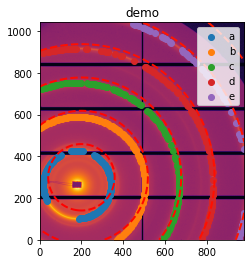

In [7]:
#Control point and rings do not overlap well initially (this was a guessed geometry)
ax = jupyter.display(sg=sg)

In [8]:
# Refine the geometry ... here in SAXS geometry, the rotation is fixed in orthogonal setup
sg.geometry_refinement.refine2(fix=["rot1", "rot2", "rot3", "wavelength"])
sg.get_ai()

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.634784e+00m	PONI= 4.543486e-02, 3.094184e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1634.784mm	Center: x=179.894, y=264.156 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

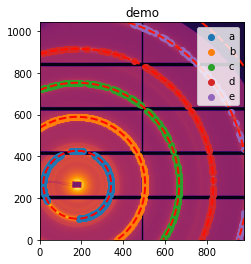

In [9]:
ax = jupyter.display(sg=sg)

In [10]:
#Save the geometry obtained
sg.geometry_refinement.save("geometry.poni")
with open("geometry.poni") as f:
    print(f.read())

# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Tue Jan 19 09:25:31 2021
poni_version: 2
Detector: Pilatus1M
Detector_config: {}
Distance: 1.634713283838036
Poni1: 0.04543617792506925
Poni2: 0.030943912285734728
Rot1: 0.0
Rot2: 0.0
Rot3: 0
Wavelength: 1e-10
# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Tue Jan 19 09:27:35 2021
poni_version: 2
Detector: Pilatus1M
Detector_config: {}
Distance: 1.6347837431388799
Poni1: 0.04543485674888853
Poni2: 0.030941837755787908
Rot1: 0.0
Rot2: 0.0
Rot3: 0
Wavelength: 1e-10



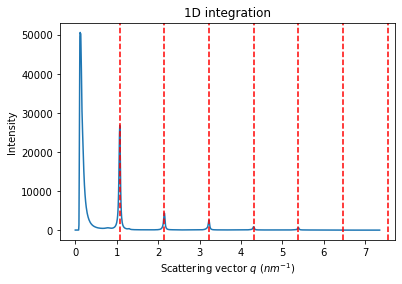

In [11]:
#Use the geometry to perform an azimuthal integration
ai = sg.get_ai()
res = ai.integrate1d(frame, 1000)
ax = jupyter.plot1d(res,calibrant=behenate)


## Conclusion

PyFAI still lacks some good integration into the Jupyter ecosystem, for example to draw a mask or pick control points, but it is nevertheless possible to calibrate an experimental setup when the approximate geometry is known.

In [12]:
print(f"Execution time: {time.perf_counter()-start_time:.3f} s")

Execution time: 3.975 s
